In [1]:
!pip install -q rlcard torch numpy matplotlib seaborn scipy pandas eval7

import rlcard
import torch
import numpy as np
import matplotlib.pyplot as plt

print("✓ All dependencies installed successfully!")
print(f"\\nRLCard version: {rlcard.__version__}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print("🚀 Training will use GPU acceleration!")
else:
    print("⚠️ No GPU detected. Training will use CPU (slower).")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.0/269.0 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 675.3/675.3 kB 27.1 MB/s eta 0:00:00
✓ All dependencies installed successfully!
\nRLCard version: 1.2.0
PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4
🚀 Training will use GPU acceleration!


In [2]:
import numpy as np
import random
import eval7

class OddsAgentV21(object):
    '''GTO-inspired poker agent using equity calculations and pot odds.'''

    def __init__(self, num_actions, threshold_offset=None):
        if threshold_offset is None:
            threshold_offset = {'preflop': 0, 'flop': 0, 'turn': 0, 'river': 0}

        self.use_raw = True
        self.num_actions = num_actions

        # Pre-calculated hand strength rankings
        self.preflop_value_dict = {
             '32o': 0.0, '42o': 0.006, '52o': 0.012, '62o': 0.018, '72o': 0.024,
             '32s': 0.030, '43o': 0.036, '63o': 0.042, '42s': 0.048, '53o': 0.054,
             '62s': 0.060, '73o': 0.065, '82o': 0.071, '72s': 0.077, '52s': 0.083,
             '54o': 0.089, '43s': 0.095, '83o': 0.101, '64o': 0.107, '74o': 0.113,
             '53s': 0.119, '63s': 0.125, '92o': 0.131, '84o': 0.137, '82s': 0.143,
             '65o': 0.149, '73s': 0.155, '83s': 0.161, '93o': 0.167, '75o': 0.173,
             '54s': 0.179, '94o': 0.185, '64s': 0.190, 'T2o': 0.196, '85o': 0.202,
             '74s': 0.208, '76o': 0.214, '84s': 0.220, '92s': 0.226, 'T3o': 0.232,
             '95o': 0.238, '65s': 0.244, '94s': 0.250, '93s': 0.256, 'T4o': 0.262,
             '86o': 0.268, '75s': 0.274, '76s': 0.280, '96o': 0.286, 'T3s': 0.292,
             'T2s': 0.298, '86s': 0.304, '87o': 0.310, 'T5o': 0.315, '85s': 0.321,
             '95s': 0.327, 'J2o': 0.333, 'J3o': 0.339, 'J2s': 0.345, '97o': 0.351,
             'T4s': 0.357, 'J4o': 0.363, '22': 0.369, 'T6o': 0.375, '96s': 0.381,
             'Q2o': 0.387, 'J5o': 0.393, 'J6o': 0.399, '98o': 0.405, '87s': 0.411,
             'Q3o': 0.417, 'T7o': 0.423, 'T6s': 0.429, 'J4s': 0.435, 'J3s': 0.440,
             'T5s': 0.446, '97s': 0.452, 'J5s': 0.458, 'Q4o': 0.464, 'Q5o': 0.470,
             'T8o': 0.476, 'J7o': 0.482, '33': 0.488, 'Q2s': 0.494, 'K2o': 0.500,
             'Q3s': 0.506, 'J6s': 0.512, '98s': 0.518, 'T7s': 0.524, 'Q6o': 0.530,
             'K3o': 0.536, 'T9o': 0.542, 'J8o': 0.548, 'T8s': 0.554, 'Q7o': 0.560,
             'Q5s': 0.565, 'Q4s': 0.571, 'J7s': 0.577, 'Q6s': 0.583, 'K2s': 0.589,
             'K4o': 0.595, 'T9s': 0.601, '44': 0.607, 'K3s': 0.613, 'J9o': 0.619,
             'K5o': 0.625, 'Q8o': 0.631, 'Q7s': 0.637, 'J8s': 0.643, 'K4s': 0.649,
             'K6o': 0.655, 'A2o': 0.661, 'Q8s': 0.667, 'K5s': 0.673, 'JTo': 0.679,
             'J9s': 0.685, 'K7o': 0.690, 'Q9o': 0.696, 'A3o': 0.702, 'K6s': 0.708,
             'A2s': 0.714, 'K8o': 0.720, '55': 0.726, 'JTs': 0.732, 'A4o': 0.738,
             'QTo': 0.744, 'K7s': 0.750, 'Q9s': 0.756, 'K8s': 0.762, 'A3s': 0.768,
             'QJo': 0.774, 'A6o': 0.780, 'A5o': 0.786, 'K9o': 0.792, 'A4s': 0.798,
             'A7o': 0.804, 'QTs': 0.810, 'A6s': 0.815, '66': 0.821, 'K9s': 0.827,
             'A5s': 0.833, 'KTo': 0.839, 'QJs': 0.845, 'A8o': 0.851, 'KJo': 0.857,
             'A9o': 0.863, 'A8s': 0.869, 'KTs': 0.875, '77': 0.881, 'KQo': 0.887,
             'A7s': 0.893, 'KJs': 0.899, 'A9s': 0.905, 'ATo': 0.911, 'AJo': 0.917,
             'KQs': 0.923, 'ATs': 0.929, 'AQo': 0.935, 'AJs': 0.940, '88': 0.946,
             'AKo': 0.952, 'AQs': 0.958, '99': 0.964, 'AKs': 0.970, 'TT': 0.976,
             'JJ': 0.982, 'QQ': 0.988, 'KK': 0.994, 'AA': 1.0
        }

        # Parameters by game stage
        base_params = {
            'threshold_re_raise': 0.80, 'threshold_open_raise': 0.70,
            'threshold_call': 0.60, 'threshold_re_raise_add': 0.05,
            'pct_raise_mix_call': 0.30, 'pct_raise_mix_check': 0.10,
            'pct_call_mix_raise': 0.25, 'pct_call_mix_fold': 0.15,
            'pct_fold_mix_call': 0.05, 'pct_fold_mix_raise': 0.10,
            'pct_check_mix_raise': 0.10, 'pct_equity_enough_raise': 0.4
        }

        self.para_all = {}
        for stage, offset in threshold_offset.items():
            params = base_params.copy()
            params['threshold_re_raise'] += offset
            params['threshold_open_raise'] += offset
            params['threshold_call'] += offset
            self.para_all[stage] = params

        # Poker ranges
        self.range_full = eval7.HandRange("A2+, K2+, Q2+, J2+, T2+, 92+, 82+, 72+, 62+, 52+, 42+, 32+, 22+")
        self.range_50 = eval7.HandRange("22+, A2s+, K2s+, Q7s+, J7s+, T7s+, 96s+, 86s+, 75s+, 64s+, 53s+, 43s, A2o+, K5o+, Q8o+, J8o+, T8o+, 98o, 87o, 76o, 65o")
        self.range_35 = eval7.HandRange("22+, A2s+, K8s+, Q8s+, J8s+, T7s+, 97s+, 86s+, 75s+, 64s+, 54s, 43s, A8o+, A5o-A2o, K9o+, Q9o+, J9o+, T9o")

    def step_generic_para(self, state, step_no):
        step_name = {0: 'preflop', 1: 'flop', 2: 'turn', 3: 'river'}[step_no]
        para_step = self.para_all[step_name]

        # Hand strength
        h1, h2 = state['raw_obs']['hand']
        hand_169 = h1[1]+h2[1] if h1[1]==h2[1] else h1[1]+h2[1]+('s' if h1[0]==h2[0] else 'o')
        my_strength = self.preflop_value_dict.get(hand_169, 0)

        # Equity calculation post-flop
        if step_no >= 1:
            cards_hand = [eval7.Card(x[1]+x[0].lower()) for x in state['raw_obs']['hand']]
            cards_public = [eval7.Card(x[1]+x[0].lower()) for x in state['raw_obs']['public_cards']]
            range_use = [self.range_full, self.range_50, self.range_35][min(step_no-1, 2)]
            my_equity = eval7.py_hand_vs_range_exact(cards_hand, range_use, cards_public)
        else:
            my_equity = 0.45

        decision_value = my_strength if step_no == 0 else my_equity

        # Decision logic
        if 'check' in state['raw_legal_actions']:
            if random.uniform(0, 1) < decision_value:
                return 'raise' if 'raise' in state['raw_legal_actions'] else 'call'
            else:
                if random.uniform(0, 1) < para_step['pct_check_mix_raise']:
                    return 'raise' if 'raise' in state['raw_legal_actions'] else 'check'
                return 'check'
        else:
            port_size = sum(state['raw_obs']['all_chips'])
            bet_amt = max(x - state['raw_obs']['my_chips'] for x in state['raw_obs']['all_chips'] if x != state['raw_obs']['my_chips'])
            bet_amt_pct = bet_amt/port_size if port_size > 0 else 0

            if decision_value > bet_amt_pct:
                if random.uniform(0, 1) < decision_value:
                    return 'raise' if 'raise' in state['raw_legal_actions'] else 'call'
                return 'call'
            else:
                if random.uniform(0, 1) < para_step['pct_fold_mix_call']:
                    return 'call'
                elif random.uniform(0, 1) < para_step['pct_fold_mix_raise']/(1-para_step['pct_fold_mix_call']):
                    return 'raise' if 'raise' in state['raw_legal_actions'] else 'call'
                return 'fold'

    def step(self, state):
        num_cards = len(state['raw_obs']['public_cards'])
        return self.step_generic_para(state, [0, 1, 2, 3][min(num_cards//3 + (1 if num_cards==4 else 0), 3)])

    def eval_step(self, state):
        probs = [0] * self.num_actions
        for i in state['legal_actions']:
            probs[i] = 1/len(state['legal_actions'])
        info = {'probs': {state['raw_legal_actions'][i]: probs[list(state['legal_actions'].keys())[i]]
                         for i in range(len(state['legal_actions']))}}
        return self.step(state), info

print("✓ OddsAgentV21 class defined")

✓ OddsAgentV21 class defined


TRAINING POKER BOT WITH NFSP
\nEnvironment: Limit Hold'em (2 players)
Training episodes: 5000
State shape: [[72], [72]]
--> Running on the GPU
Training on: cuda:0
\n Trainable: NFSP
  Benchmark: OddsAgentV21
\n================================================================================
STARTING TRAINING
================================================================================\n

----------------------------------------
  episode      |  2657
  reward       |  -0.445
----------------------------------------
Episode    0/5000 | Performance: -0.4450

----------------------------------------
  episode      |  5298
  reward       |  -0.5145
----------------------------------------
Episode   50/5000 | Performance: -0.5145
INFO - Step 100, rl-loss: 5.951033115386963
INFO - Copied model parameters to target network.
INFO - Step 159, rl-loss: 1.7108876705169678
----------------------------------------
  episode      |  9337
  reward       |  -0.7825
----------------------------------

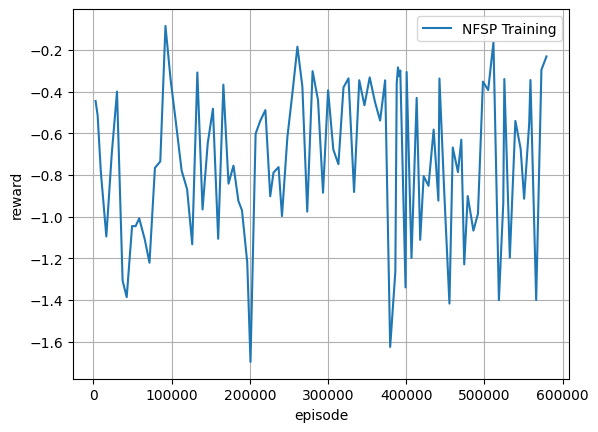

In [3]:
import rlcard
from rlcard.agents import NFSPAgent, RandomAgent
from rlcard.utils import tournament, reorganize, Logger, plot_curve, get_device
import os
import json
import re
from collections import defaultdict

print("="*80)
print("TRAINING POKER BOT WITH NFSP")
print("="*80)

# Configuration
EPOCHS = 5000  # Can reduce to 2000 for faster testing
EVAL_EVERY = 50
EVAL_GAMES = 1000

# Setup environment
env = rlcard.make('limit-holdem', config={
    'seed': 42,
    'allow_step_back': True,
    'game_num_players': 2
})

print(f"\\nEnvironment: Limit Hold'em (2 players)")
print(f"Training episodes: {EPOCHS}")
print(f"State shape: {env.state_shape}")

# Get device
device = get_device()
print(f"Training on: {device}")

# Initialize agents
agent = NFSPAgent(
    num_actions=env.num_actions,
    state_shape=env.state_shape[0],
    hidden_layers_sizes=[64, 64],
    q_mlp_layers=[64, 64],
    device=device,
    evaluate_with='best_response'
)

agent_bench = OddsAgentV21(num_actions=env.num_actions)
env.set_agents([agent, agent_bench])

print(f"\\n Trainable: NFSP")
print(f"  Benchmark: OddsAgentV21")

# Training metrics tracking
training_metrics = {
    'episodes': [],
    'performance': [],
    'rl_losses': [],
    'sl_losses': [],
    'episode_rewards': [],
    'timesteps': []
}

# Training
log_dir = './experiments/colab_results/'
os.makedirs(log_dir, exist_ok=True)

print(f"\\n{'='*80}")
print("STARTING TRAINING")
print(f"{'='*80}\\n")

# Capture stdout to extract loss information
import sys
from io import StringIO
import logging

class LossCapture:
    """Capture RL loss values from logging output"""
    def __init__(self):
        self.losses = []
        self.original_stdout = sys.stdout
        self.capture = StringIO()

    def write(self, text):
        self.original_stdout.write(text)
        self.capture.write(text)
        # Extract RL loss from INFO messages (format: "INFO - Step X, rl-loss: Y")
        if 'rl-loss:' in text:
            match = re.search(r'rl-loss:\s*([\d.]+)', text)
            if match:
                self.losses.append(float(match.group(1)))

    def flush(self):
        self.original_stdout.flush()

# Initialize loss capture
loss_capture = LossCapture()

with Logger(log_dir) as logger:
    for episode in range(EPOCHS):
        trajectories, payoffs = env.run(is_training=True)
        trajectories = reorganize(trajectories, payoffs)

        # Track episode reward
        episode_reward = payoffs[0]
        training_metrics['episode_rewards'].append(episode_reward)
        training_metrics['episodes'].append(episode)
        training_metrics['timesteps'].append(env.timestep)

        for ts in trajectories[0]:
            agent.feed(ts)

        if episode % EVAL_EVERY == 0:
            performance = tournament(env, EVAL_GAMES)[0]
            logger.log_performance(env.timestep, performance)
            training_metrics['performance'].append(performance)

            # Get recent RL losses (from last 20 steps if available)
            recent_losses = loss_capture.losses[-20:] if len(loss_capture.losses) > 0 else []
            avg_rl_loss = np.mean(recent_losses) if recent_losses else 0.0
            training_metrics['rl_losses'].append(avg_rl_loss)

            loss_info = f" | Avg RL Loss: {avg_rl_loss:.4f}" if avg_rl_loss > 0 else ""
            print(f"Episode {episode:4d}/{EPOCHS} | Performance: {performance:+.4f}{loss_info}")

    print(f"\\n{'='*80}")
    print("TRAINING COMPLETE!")
    print(f"{'='*80}")

    final_performance = tournament(env, EVAL_GAMES)[0]
    print(f"\\nFinal Performance: {final_performance:+.4f}")

    csv_path, fig_path = logger.csv_path, logger.fig_path

# Save training metrics
metrics_path = os.path.join(log_dir, 'training_metrics.json')
with open(metrics_path, 'w') as f:
    json.dump(training_metrics, f, indent=2)
print(f"✓ Training metrics saved to: {metrics_path}")

plot_curve(csv_path, fig_path, "NFSP Training")
print(f"✓ Plot saved to: {fig_path}")

In [4]:
from scipy import stats
import pandas as pd

def evaluate_h2h(agent1, agent2, name1, name2, num_games=5000):
    print(f"\\n{'='*80}")
    print(f"TOURNAMENT: {name1} vs {name2}")
    print(f"{'='*80}")

    env_eval = rlcard.make('limit-holdem', config={'seed': 123, 'game_num_players': 2})
    env_eval.set_agents([agent1, agent2])

    payoffs_1 = []
    for i in range(num_games):
        if (i+1) % 1000 == 0:
            print(f"  {i+1}/{num_games}", end='\\r')
        _, payoffs = env_eval.run(is_training=False)
        payoffs_1.append(payoffs[0])

    payoffs_1 = np.array(payoffs_1)
    wins = np.sum(payoffs_1 > 0)
    losses = np.sum(payoffs_1 < 0)
    ties = np.sum(payoffs_1 == 0)

    mean = np.mean(payoffs_1)
    se = np.std(payoffs_1, ddof=1) / np.sqrt(num_games)
    ci = stats.t.interval(0.95, num_games-1, loc=mean, scale=se)
    t_stat, p_val = stats.ttest_1samp(payoffs_1, 0)

    bb_100 = (mean / 2) * 100
    win_rate = wins/num_games*100

    print(f"\\n\\n{name1}:")
    print(f"  Mean Payoff: {mean:+.4f} ± {se:.4f}")
    print(f"  95% CI: [{ci[0]:+.4f}, {ci[1]:+.4f}]")
    print(f"  Win Rate: {win_rate:.2f}%")
    print(f"  BB/100: {bb_100:+.2f}")
    print(f"  Record: {wins}-{losses}-{ties}")
    print(f"  p-value: {p_val:.6f}")

    if p_val < 0.01:
        print(f"  *** HIGHLY SIGNIFICANT ***")
    elif p_val < 0.05:
        print(f"  ** SIGNIFICANT **")

    return {'mean': mean, 'win_rate': win_rate, 'bb_100': bb_100, 'p_value': p_val}

# Run evaluations
random_agent = RandomAgent(num_actions=env.num_actions)

results = {}
results['vs_odds'] = evaluate_h2h(agent, agent_bench, "NFSP", "OddsV21", 5000)
results['vs_random'] = evaluate_h2h(agent, random_agent, "NFSP", "Random", 5000)
results['odds_vs_random'] = evaluate_h2h(agent_bench, random_agent, "OddsV21", "Random", 5000)

# Summary
print(f"\\n{'='*80}")
print("SUMMARY")
print(f"{'='*80}\\n")
for name, res in results.items():
    print(f"{name:20s}: Mean={res['mean']:+.4f}, WR={res['win_rate']:.1f}%, BB/100={res['bb_100']:+.2f}")

\n================================================================================
TOURNAMENT: NFSP vs OddsV21
  1000/5000\r  2000/5000\r  3000/5000\r  4000/5000\r  5000/5000\r\n\nNFSP:
  Mean Payoff: -0.9938 ± 0.1250
  95% CI: [-1.2388, -0.7488]
  Win Rate: 78.34%
  BB/100: -49.69
  Record: 3917-1025-58
  p-value: 0.000000
  *** HIGHLY SIGNIFICANT ***
\n================================================================================
TOURNAMENT: NFSP vs Random
  1000/5000\r  2000/5000\r  3000/5000\r  4000/5000\r  5000/5000\r\n\nNFSP:
  Mean Payoff: +2.4461 ± 0.0448
  95% CI: [+2.3583, +2.5339]
  Win Rate: 96.40%
  BB/100: +122.30
  Record: 4820-163-17
  p-value: 0.000000
  *** HIGHLY SIGNIFICANT ***
\n================================================================================
TOURNAMENT: OddsV21 vs Random
  1000/5000\r  2000/5000\r  3000/5000\r  4000/5000\r  5000/5000\r\n\nOddsV21:
  Mean Payoff: +0.8313 ± 0.0400
  95% CI: [+0.7529, +0.9097]
  Win Rate: 56.22%
  BB/100: +41.57
  R

✓ Loaded training metrics


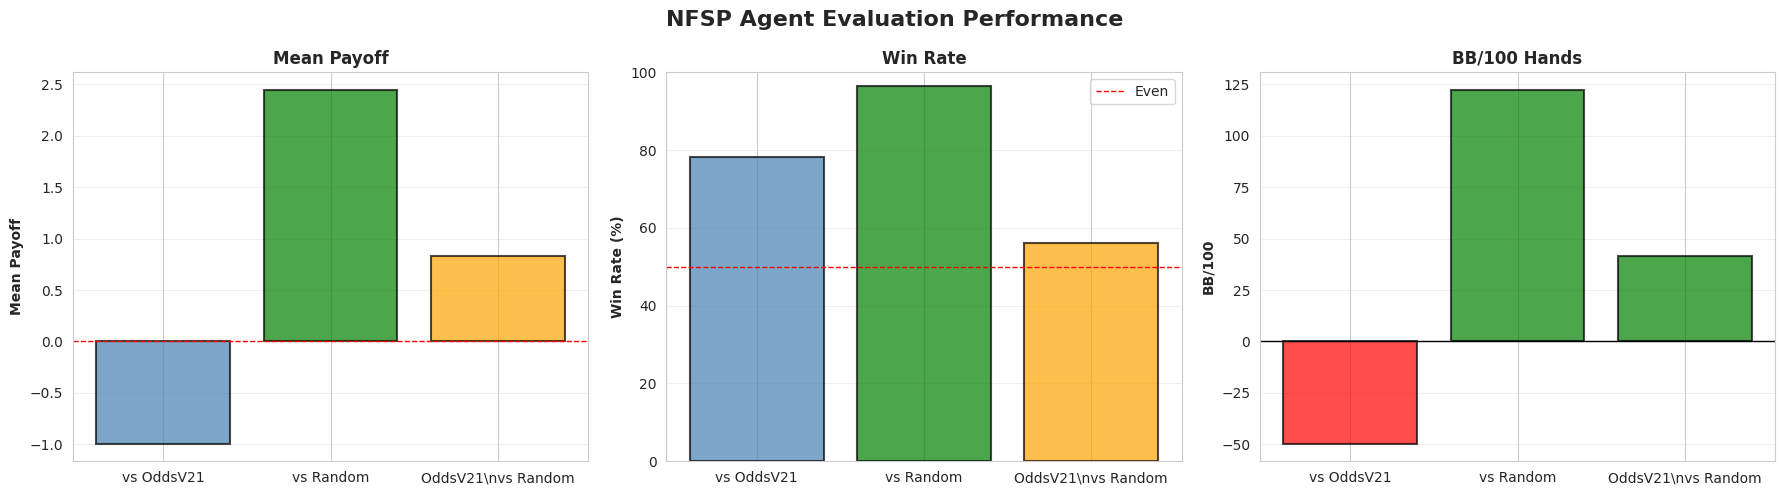

Available agent attributes: ['checkpoint_attributes', 'device', 'eval_step', 'evaluate_with', 'feed', 'from_checkpoint', 'policy_network', 'policy_network_optimizer', 'sample_episode_policy', 'save_checkpoint', 'save_every', 'save_path', 'set_device', 'step', 'total_t', 'train_sl', 'train_t', 'use_raw']
⚠ Could not find network attributes. Saving metadata only.
✓ Model saved
\n================================================================================
All plots generated. Check ./experiments/colab_results/ for saved figures.


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import torch
import pandas as pd
from scipy import stats
from scipy.ndimage import uniform_filter1d

# Check if running in Colab
try:
    from google.colab import files
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

# Load training metrics if available
metrics_path = './experiments/colab_results/training_metrics.json'
if os.path.exists(metrics_path):
    with open(metrics_path, 'r') as f:
        training_metrics = json.load(f)
    print("✓ Loaded training metrics")
else:
    print("⚠ Training metrics not found. Run training cell first.")
    training_metrics = None

# Create evaluation performance plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('NFSP Agent Evaluation Performance', fontsize=16, fontweight='bold')

matchups = ['vs OddsV21', 'vs Random', 'OddsV21\\nvs Random']
means = [results['vs_odds']['mean'], results['vs_random']['mean'], results['odds_vs_random']['mean']]
win_rates = [results['vs_odds']['win_rate'], results['vs_random']['win_rate'], results['odds_vs_random']['win_rate']]
bb_100s = [results['vs_odds']['bb_100'], results['vs_random']['bb_100'], results['odds_vs_random']['bb_100']]

axes[0].bar(matchups, means, color=['steelblue','green','orange'], alpha=0.7, edgecolor='black', linewidth=1.5)
axes[0].axhline(0, color='red', linestyle='--', linewidth=1)
axes[0].set_ylabel('Mean Payoff', fontweight='bold')
axes[0].set_title('Mean Payoff', fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

axes[1].bar(matchups, win_rates, color=['steelblue','green','orange'], alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1].axhline(50, color='red', linestyle='--', label='Even', linewidth=1)
axes[1].set_ylabel('Win Rate (%)', fontweight='bold')
axes[1].set_title('Win Rate', fontweight='bold')
axes[1].set_ylim([0, 100])
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

axes[2].bar(matchups, bb_100s, color=['green' if bb>0 else 'red' for bb in bb_100s], alpha=0.7, edgecolor='black', linewidth=1.5)
axes[2].axhline(0, color='black', linestyle='-', linewidth=1)
axes[2].set_ylabel('BB/100', fontweight='bold')
axes[2].set_title('BB/100 Hands', fontweight='bold')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('./experiments/colab_results/evaluation_performance.png', dpi=300, bbox_inches='tight')
plt.show()

# Save model (use final_performance from training if available, otherwise use last result)
try:
    final_perf = final_performance
except NameError:
    final_perf = results['vs_odds']['mean']  # Fallback

# Try to save model - NFSPAgent structure may vary by version
try:
    # First, check if agent has a save method
    if hasattr(agent, 'save'):
        agent.save('./experiments/colab_results/trained_model.pth')
        print("✓ Model saved using agent.save() method")
    else:
        # Try to access networks directly
        model_dict = {
            'episodes': EPOCHS,
            'final_performance': final_perf
        }

        # Check for different possible attribute structures
        if hasattr(agent, 'q_estimator') and hasattr(agent.q_estimator, 'qnet'):
            model_dict['q_net'] = agent.q_estimator.qnet.state_dict()
            model_dict['policy_net'] = agent.policy_net.state_dict()
        elif hasattr(agent, 'q_network'):
            model_dict['q_net'] = agent.q_network.state_dict()
            if hasattr(agent, 'policy_network'):
                model_dict['policy_net'] = agent.policy_network.state_dict()
        elif hasattr(agent, 'q_net'):
            model_dict['q_net'] = agent.q_net.state_dict()
            if hasattr(agent, 'policy_net'):
                model_dict['policy_net'] = agent.policy_net.state_dict()
        else:
            # Print available attributes for debugging
            print("Available agent attributes:", [attr for attr in dir(agent) if not attr.startswith('_')])
            print("⚠ Could not find network attributes. Saving metadata only.")

        torch.save(model_dict, './experiments/colab_results/trained_model.pth')
        print("✓ Model saved")

except Exception as e:
    print(f"⚠ Could not save model: {e}")
    print("   Model training completed successfully, but model weights were not saved.")
    print("   You can still use the agent object for evaluation.")
    print(f"   Available agent attributes: {[attr for attr in dir(agent) if not attr.startswith('_')][:10]}")

print("\\n" + "="*80)
print("All plots generated. Check ./experiments/colab_results/ for saved figures.")
print("="*80)

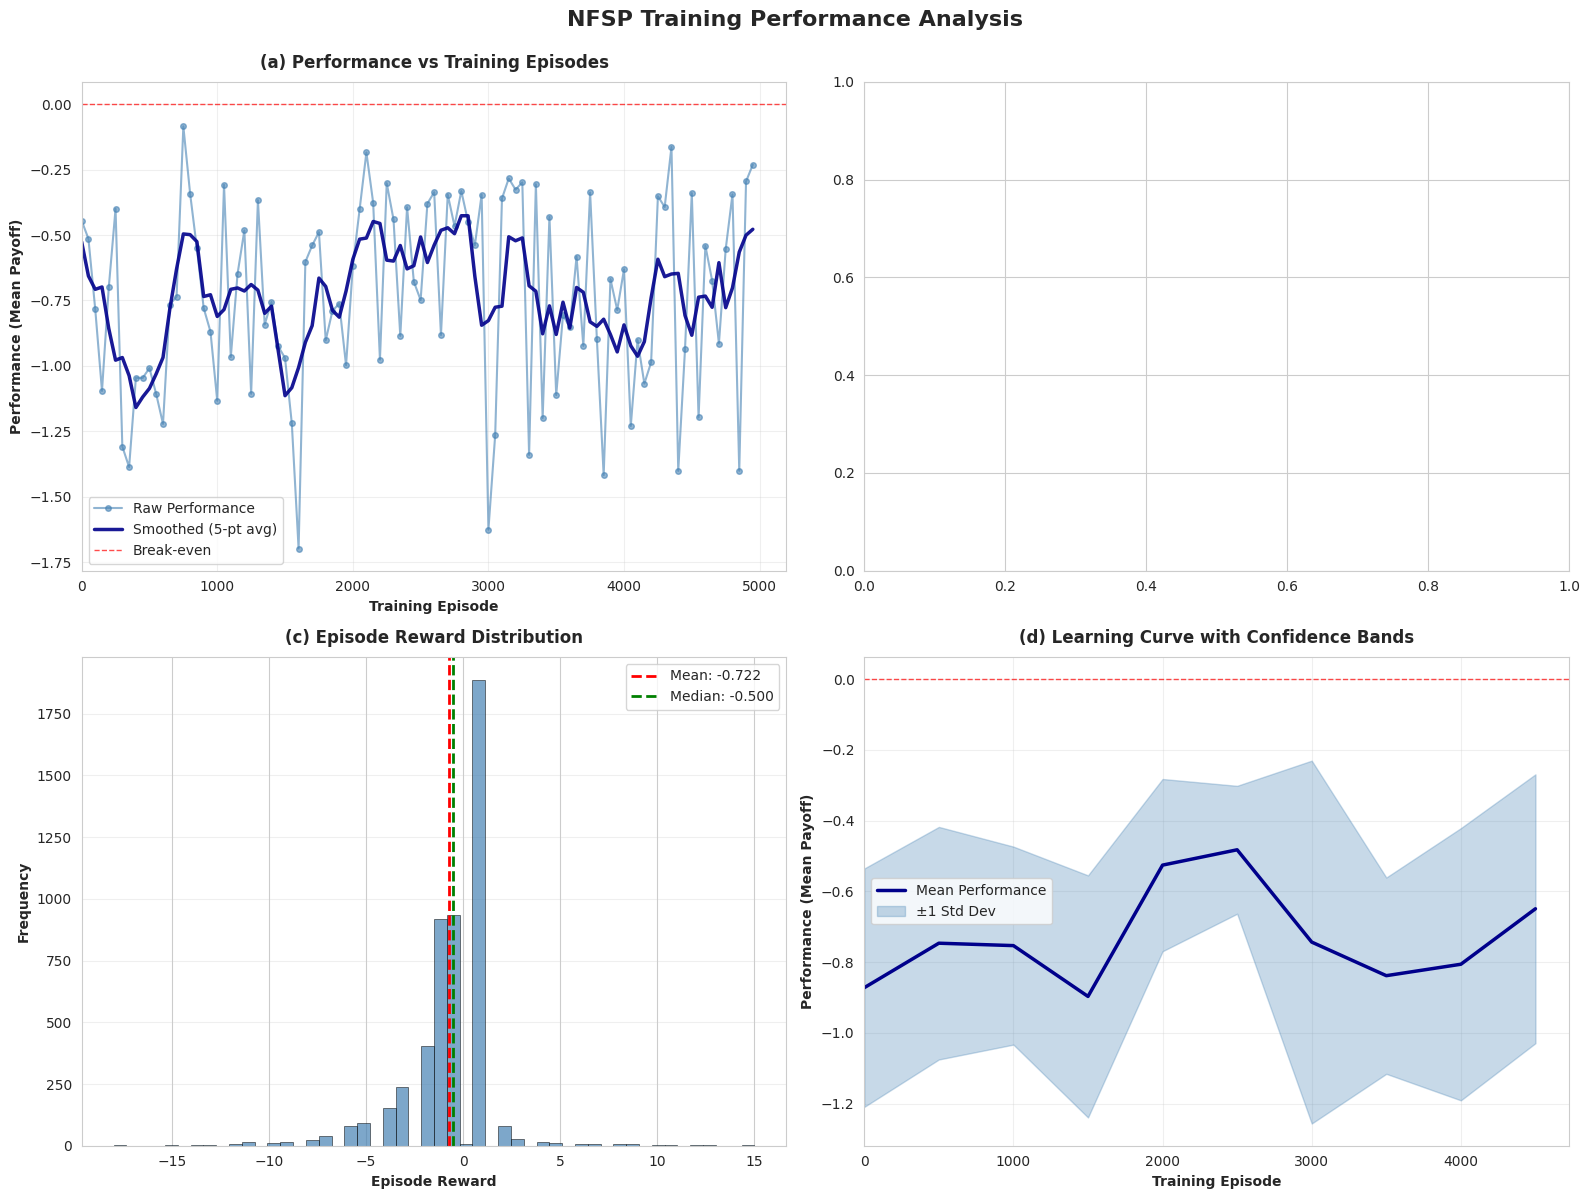

✓ Figure 1: Training Performance Analysis saved


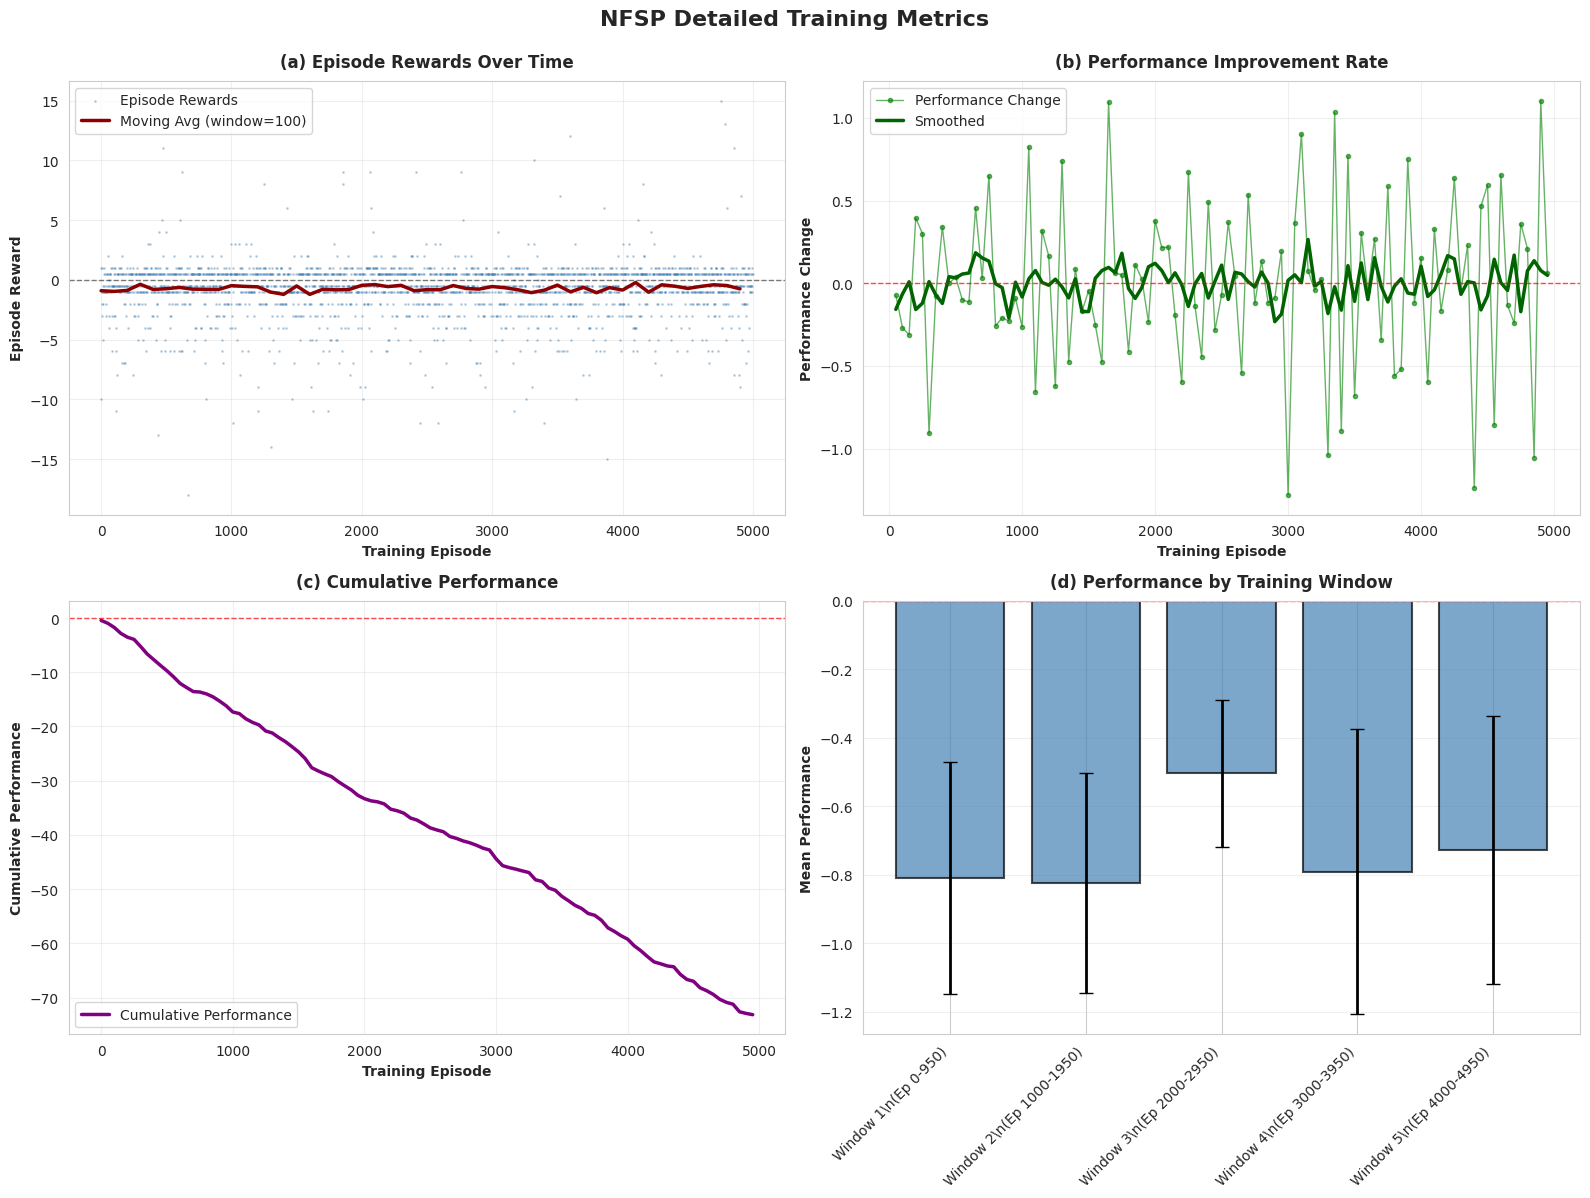

✓ Figure 2: Detailed Training Metrics saved


/tmp/ipython-input-1223110838.py:272: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax1.boxplot(phase_data, labels=phase_labels, patch_artist=True,


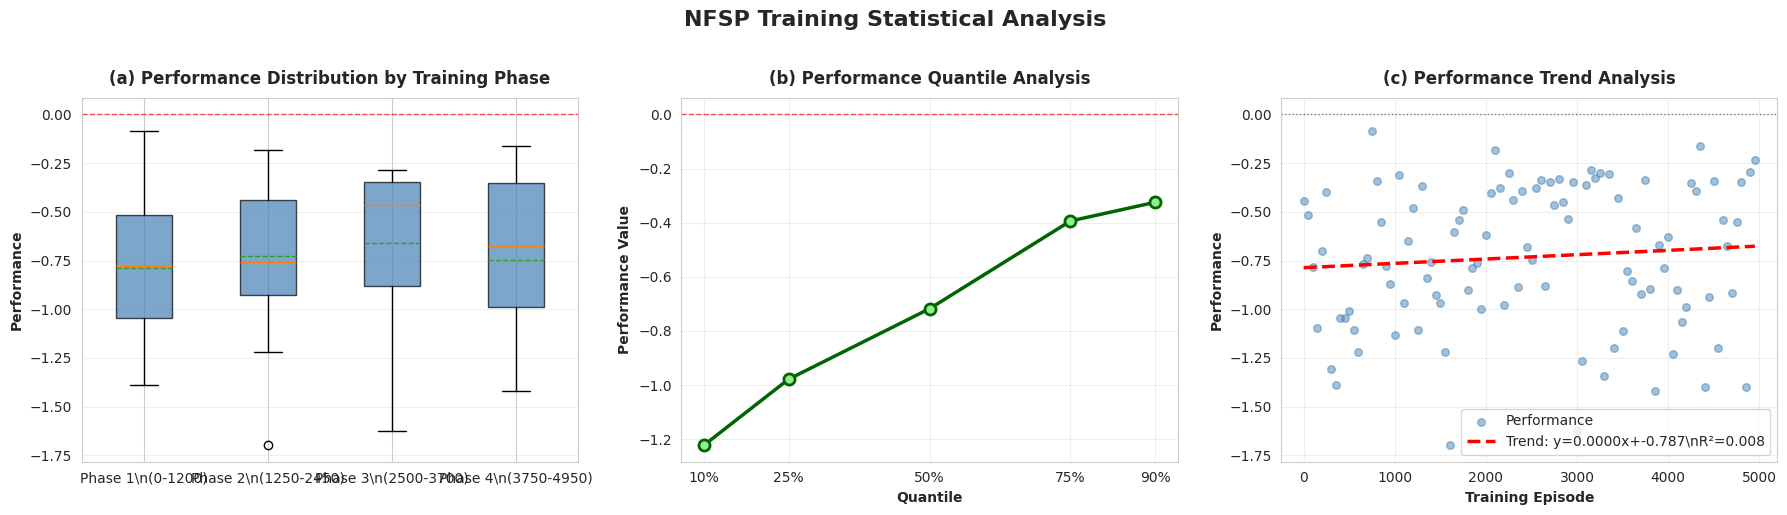

✓ Figure 3: Statistical Analysis saved
\n================================================================================
TRAINING SUMMARY STATISTICS
Initial Performance: -0.4450
Final Performance: -0.2315
Best Performance: -0.0850 (at episode 750)
Worst Performance: -1.6975 (at episode 1600)
Mean Performance: -0.7315 ± +0.3630
Performance Improvement: +0.2135
Trend Slope: 0.000022 (R²=0.008, p=0.3813)
\nEpisode Rewards:
  Mean: -0.7218 ± +2.2504
  Median: -0.5000
  Min: -18.0000, Max: +15.0000


In [6]:
# ============================================================================
# COMPREHENSIVE TRAINING ANALYSIS - RESEARCH GRADE GRAPHS
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.ndimage import uniform_filter1d
from scipy import stats
import os

# Load training metrics
metrics_path = './experiments/colab_results/training_metrics.json'
if not os.path.exists(metrics_path):
    print("⚠ Training metrics not found. Please run the training cell first.")
else:
    with open(metrics_path, 'r') as f:
        training_metrics = json.load(f)

    # Convert to numpy arrays for easier manipulation
    episodes = np.array(training_metrics['episodes'])
    performance = np.array(training_metrics['performance'])
    rl_losses = np.array(training_metrics['rl_losses'])
    episode_rewards = np.array(training_metrics['episode_rewards'])

    # Get EVAL_EVERY from training config (default to 50 if not available)
    try:
        eval_every = EVAL_EVERY
    except NameError:
        eval_every = 50  # Default value

    eval_episodes = np.array([episodes[i] for i in range(0, len(episodes), eval_every)][:len(performance)])

    # Smoothing function
    def smooth_curve(data, window=10):
        if len(data) < window:
            return data
        return uniform_filter1d(data.astype(float), size=window, mode='nearest')

    # ========================================================================
    # FIGURE 1: Training Performance Curves
    # ========================================================================
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('NFSP Training Performance Analysis', fontsize=16, fontweight='bold', y=0.995)

    # 1.1 Performance over training episodes
    ax1 = axes[0, 0]
    if len(performance) > 0:
        ax1.plot(eval_episodes, performance, 'o-', color='steelblue', markersize=4, linewidth=1.5,
                label='Raw Performance', alpha=0.6)
        if len(performance) > 5:
            smoothed = smooth_curve(performance, window=min(5, len(performance)//3))
            ax1.plot(eval_episodes[:len(smoothed)], smoothed, '-', color='darkblue',
                    linewidth=2.5, label='Smoothed (5-pt avg)', alpha=0.9)
        ax1.axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.7, label='Break-even')
        ax1.set_xlabel('Training Episode', fontweight='bold')
        ax1.set_ylabel('Performance (Mean Payoff)', fontweight='bold')
        ax1.set_title('(a) Performance vs Training Episodes', fontweight='bold', pad=10)
        ax1.legend(loc='best')
        ax1.grid(True, alpha=0.3)
        ax1.set_xlim(left=0)

    # 1.2 RL Loss over training
    ax2 = axes[0, 1]
    if len(rl_losses) > 0 and np.any(rl_losses > 0):
        valid_losses = rl_losses[rl_losses > 0]
        valid_episodes = eval_episodes[rl_losses > 0]
        if len(valid_losses) > 0:
            ax2.plot(valid_episodes, valid_losses, 'o-', color='crimson', markersize=4,
                    linewidth=1.5, label='RL Loss', alpha=0.7)
            if len(valid_losses) > 3:
                smoothed_loss = smooth_curve(valid_losses, window=min(3, len(valid_losses)//2))
                ax2.plot(valid_episodes[:len(smoothed_loss)], smoothed_loss, '-',
                        color='darkred', linewidth=2.5, label='Smoothed', alpha=0.9)
            ax2.set_xlabel('Training Episode', fontweight='bold')
            ax2.set_ylabel('RL Loss', fontweight='bold')
            ax2.set_title('(b) RL Loss vs Training Episodes', fontweight='bold', pad=10)
            ax2.legend(loc='best')
            ax2.grid(True, alpha=0.3)
            ax2.set_yscale('log')
            ax2.set_xlim(left=0)

    # 1.3 Episode rewards distribution
    ax3 = axes[1, 0]
    if len(episode_rewards) > 0:
        # Sample for large datasets
        sample_size = min(5000, len(episode_rewards))
        if len(episode_rewards) > sample_size:
            sample_indices = np.random.choice(len(episode_rewards), sample_size, replace=False)
            sampled_rewards = episode_rewards[sample_indices]
        else:
            sampled_rewards = episode_rewards

        ax3.hist(sampled_rewards, bins=50, color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)
        ax3.axvline(np.mean(episode_rewards), color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {np.mean(episode_rewards):.3f}')
        ax3.axvline(np.median(episode_rewards), color='green', linestyle='--', linewidth=2,
                   label=f'Median: {np.median(episode_rewards):.3f}')
        ax3.set_xlabel('Episode Reward', fontweight='bold')
        ax3.set_ylabel('Frequency', fontweight='bold')
        ax3.set_title('(c) Episode Reward Distribution', fontweight='bold', pad=10)
        ax3.legend(loc='best')
        ax3.grid(True, alpha=0.3, axis='y')

    # 1.4 Learning curve with confidence intervals
    ax4 = axes[1, 1]
    if len(performance) > 0:
        # Calculate rolling statistics
        window = min(10, len(performance)//4) if len(performance) > 20 else 3
        if window > 1 and len(performance) >= window:
            rolling_mean = []
            rolling_std = []
            rolling_episodes = []

            for i in range(0, len(performance), window):
                end_idx = min(i + window, len(performance))
                window_perf = performance[i:end_idx]
                rolling_mean.append(np.mean(window_perf))
                rolling_std.append(np.std(window_perf))
                rolling_episodes.append(eval_episodes[i])

            rolling_mean = np.array(rolling_mean)
            rolling_std = np.array(rolling_std)
            rolling_episodes = np.array(rolling_episodes)

            ax4.plot(rolling_episodes, rolling_mean, '-', color='darkblue', linewidth=2.5, label='Mean Performance')
            ax4.fill_between(rolling_episodes,
                           rolling_mean - rolling_std,
                           rolling_mean + rolling_std,
                           alpha=0.3, color='steelblue', label='±1 Std Dev')
            ax4.axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.7)
        else:
            ax4.plot(eval_episodes, performance, '-', color='darkblue', linewidth=2.5, label='Performance')
            ax4.axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.7)

        ax4.set_xlabel('Training Episode', fontweight='bold')
        ax4.set_ylabel('Performance (Mean Payoff)', fontweight='bold')
        ax4.set_title('(d) Learning Curve with Confidence Bands', fontweight='bold', pad=10)
        ax4.legend(loc='best')
        ax4.grid(True, alpha=0.3)
        ax4.set_xlim(left=0)

    plt.tight_layout()
    plt.savefig('./experiments/colab_results/training_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Figure 1: Training Performance Analysis saved")

    # ========================================================================
    # FIGURE 2: Detailed Training Metrics
    # ========================================================================
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('NFSP Detailed Training Metrics', fontsize=16, fontweight='bold', y=0.995)

    # 2.1 Reward progression over time
    ax1 = axes[0, 0]
    if len(episode_rewards) > 0:
        # Downsample for visualization if too many points
        max_points = 2000
        if len(episode_rewards) > max_points:
            step = len(episode_rewards) // max_points
            plot_rewards = episode_rewards[::step]
            plot_episodes = episodes[::step]
        else:
            plot_rewards = episode_rewards
            plot_episodes = episodes

        ax1.scatter(plot_episodes, plot_rewards, alpha=0.3, s=1, color='steelblue', label='Episode Rewards')

        # Add moving average
        if len(episode_rewards) > 100:
            window = 100
            moving_avg = []
            moving_episodes = []
            for i in range(0, len(episode_rewards), window):
                end_idx = min(i + window, len(episode_rewards))
                moving_avg.append(np.mean(episode_rewards[i:end_idx]))
                moving_episodes.append(episodes[i])
            ax1.plot(moving_episodes, moving_avg, '-', color='darkred', linewidth=2.5,
                    label=f'Moving Avg (window={window})')

        ax1.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
        ax1.set_xlabel('Training Episode', fontweight='bold')
        ax1.set_ylabel('Episode Reward', fontweight='bold')
        ax1.set_title('(a) Episode Rewards Over Time', fontweight='bold', pad=10)
        ax1.legend(loc='best')
        ax1.grid(True, alpha=0.3)

    # 2.2 Performance improvement rate
    ax2 = axes[0, 1]
    if len(performance) > 1:
        performance_diff = np.diff(performance)
        eval_episodes_diff = eval_episodes[1:]
        ax2.plot(eval_episodes_diff, performance_diff, 'o-', color='green', markersize=3,
                linewidth=1, alpha=0.6, label='Performance Change')
        if len(performance_diff) > 5:
            smoothed_diff = smooth_curve(performance_diff, window=min(5, len(performance_diff)//3))
            ax2.plot(eval_episodes_diff[:len(smoothed_diff)], smoothed_diff, '-',
                    color='darkgreen', linewidth=2.5, label='Smoothed')
        ax2.axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.7)
        ax2.set_xlabel('Training Episode', fontweight='bold')
        ax2.set_ylabel('Performance Change', fontweight='bold')
        ax2.set_title('(b) Performance Improvement Rate', fontweight='bold', pad=10)
        ax2.legend(loc='best')
        ax2.grid(True, alpha=0.3)

    # 2.3 Cumulative performance
    ax3 = axes[1, 0]
    if len(performance) > 0:
        cumulative_perf = np.cumsum(performance)
        ax3.plot(eval_episodes, cumulative_perf, '-', color='purple', linewidth=2.5, label='Cumulative Performance')
        ax3.axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.7)
        ax3.set_xlabel('Training Episode', fontweight='bold')
        ax3.set_ylabel('Cumulative Performance', fontweight='bold')
        ax3.set_title('(c) Cumulative Performance', fontweight='bold', pad=10)
        ax3.legend(loc='best')
        ax3.grid(True, alpha=0.3)

    # 2.4 Performance statistics over time windows
    ax4 = axes[1, 1]
    if len(performance) > 10:
        # Divide into time windows
        n_windows = 5
        window_size = len(performance) // n_windows
        window_means = []
        window_stds = []
        window_labels = []

        for i in range(n_windows):
            start_idx = i * window_size
            end_idx = (i + 1) * window_size if i < n_windows - 1 else len(performance)
            window_perf = performance[start_idx:end_idx]
            window_means.append(np.mean(window_perf))
            window_stds.append(np.std(window_perf))
            window_labels.append(f'Window {i+1}\\n(Ep {eval_episodes[start_idx]}-{eval_episodes[end_idx-1]})')

        x_pos = np.arange(n_windows)
        ax4.bar(x_pos, window_means, yerr=window_stds, color='steelblue', alpha=0.7,
               edgecolor='black', linewidth=1.5, capsize=5, error_kw={'linewidth': 2})
        ax4.axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.7)
        ax4.set_xticks(x_pos)
        ax4.set_xticklabels(window_labels, rotation=45, ha='right')
        ax4.set_ylabel('Mean Performance', fontweight='bold')
        ax4.set_title('(d) Performance by Training Window', fontweight='bold', pad=10)
        ax4.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig('./experiments/colab_results/detailed_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Figure 2: Detailed Training Metrics saved")

    # ========================================================================
    # FIGURE 3: Statistical Analysis
    # ========================================================================
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('NFSP Training Statistical Analysis', fontsize=16, fontweight='bold', y=1.02)

    # 3.1 Performance box plot by training phase
    ax1 = axes[0]
    if len(performance) > 10:
        n_phases = 4
        phase_size = len(performance) // n_phases
        phase_data = []
        phase_labels = []

        for i in range(n_phases):
            start_idx = i * phase_size
            end_idx = (i + 1) * phase_size if i < n_phases - 1 else len(performance)
            phase_data.append(performance[start_idx:end_idx])
            phase_labels.append(f'Phase {i+1}\\n({eval_episodes[start_idx]}-{eval_episodes[end_idx-1]})')

        bp = ax1.boxplot(phase_data, labels=phase_labels, patch_artist=True,
                        showmeans=True, meanline=True)
        for patch in bp['boxes']:
            patch.set_facecolor('steelblue')
            patch.set_alpha(0.7)
        ax1.axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.7)
        ax1.set_ylabel('Performance', fontweight='bold')
        ax1.set_title('(a) Performance Distribution by Training Phase', fontweight='bold', pad=10)
        ax1.grid(True, alpha=0.3, axis='y')

    # 3.2 Performance quantiles
    ax2 = axes[1]
    if len(performance) > 0:
        quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
        quantile_values = [np.quantile(performance, q) for q in quantiles]
        ax2.plot(quantiles, quantile_values, 'o-', color='darkgreen', linewidth=2.5,
                markersize=8, markerfacecolor='lightgreen', markeredgecolor='darkgreen',
                markeredgewidth=2)
        ax2.axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.7)
        ax2.set_xlabel('Quantile', fontweight='bold')
        ax2.set_ylabel('Performance Value', fontweight='bold')
        ax2.set_title('(b) Performance Quantile Analysis', fontweight='bold', pad=10)
        ax2.set_xticks(quantiles)
        ax2.set_xticklabels([f'{q*100:.0f}%' for q in quantiles])
        ax2.grid(True, alpha=0.3)

    # 3.3 Performance trend analysis
    ax3 = axes[2]
    if len(performance) > 2:
        # Linear regression
        x = eval_episodes
        y = performance
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        trend_line = slope * x + intercept

        ax3.scatter(x, y, alpha=0.5, s=30, color='steelblue', label='Performance')
        ax3.plot(x, trend_line, '--', color='red', linewidth=2.5,
                label=f'Trend: y={slope:.4f}x+{intercept:.3f}\\nR²={r_value**2:.3f}')
        ax3.axhline(0, color='black', linestyle=':', linewidth=1, alpha=0.5)
        ax3.set_xlabel('Training Episode', fontweight='bold')
        ax3.set_ylabel('Performance', fontweight='bold')
        ax3.set_title('(c) Performance Trend Analysis', fontweight='bold', pad=10)
        ax3.legend(loc='best')
        ax3.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('./experiments/colab_results/statistical_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Figure 3: Statistical Analysis saved")

    # Print summary statistics
    print("\\n" + "="*80)
    print("TRAINING SUMMARY STATISTICS")
    print("="*80)
    if len(performance) > 0:
        print(f"Initial Performance: {performance[0]:+.4f}")
        print(f"Final Performance: {performance[-1]:+.4f}")
        print(f"Best Performance: {np.max(performance):+.4f} (at episode {eval_episodes[np.argmax(performance)]})")
        print(f"Worst Performance: {np.min(performance):+.4f} (at episode {eval_episodes[np.argmin(performance)]})")
        print(f"Mean Performance: {np.mean(performance):+.4f} ± {np.std(performance):+.4f}")
        print(f"Performance Improvement: {performance[-1] - performance[0]:+.4f}")
        if len(performance) > 1:
            slope, _, r_value, p_value, _ = stats.linregress(eval_episodes, performance)
            print(f"Trend Slope: {slope:.6f} (R²={r_value**2:.3f}, p={p_value:.4f})")

    if len(episode_rewards) > 0:
        print(f"\\nEpisode Rewards:")
        print(f"  Mean: {np.mean(episode_rewards):+.4f} ± {np.std(episode_rewards):+.4f}")
        print(f"  Median: {np.median(episode_rewards):+.4f}")
        print(f"  Min: {np.min(episode_rewards):+.4f}, Max: {np.max(episode_rewards):+.4f}")

    print("="*80)


In [7]:
# ============================================================================
# DOWNLOAD ALL RESULTS FOR RESEARCH PAPER
# ============================================================================

import shutil
import os
from pathlib import Path

# Check if running in Colab
try:
    from google.colab import files
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

results_dir = './experiments/colab_results/'

# List all generated files
print("="*80)
print("GENERATED FILES FOR RESEARCH PAPER")
print("="*80)

if os.path.exists(results_dir):
    files_list = []
    for file in os.listdir(results_dir):
        file_path = os.path.join(results_dir, file)
        if os.path.isfile(file_path):
            size = os.path.getsize(file_path) / 1024  # KB
            files_list.append((file, size))
            print(f"  ✓ {file:40s} ({size:.1f} KB)")

    print(f"\\nTotal files: {len(files_list)}")

    # Create zip archive
    if IN_COLAB:
        zip_path = '/content/poker_results.zip'
    else:
        zip_path = './poker_results.zip'

    shutil.make_archive(zip_path.replace('.zip', ''), 'zip', results_dir)
    print(f"\\n✓ Created archive: {zip_path}")

    # Download if in Colab
    if IN_COLAB:
        print("\\nDownloading results...")
        files.download(zip_path)
        print("✓ Download complete! Extract and use in your research paper.")
    else:
        print(f"\\n✓ Archive saved at: {os.path.abspath(zip_path)}")
        print("  You can find all generated graphs in: ./experiments/colab_results/")

    print("\\n" + "="*80)
    print("GRAPH FILES SUMMARY:")
    print("="*80)
    print("1. evaluation_performance.png - Final evaluation results")
    print("2. training_analysis.png - Main training performance curves")
    print("3. detailed_metrics.png - Detailed training metrics")
    print("4. statistical_analysis.png - Statistical analysis plots")
    print("5. training_metrics.json - Raw training data (for further analysis)")
    print("6. trained_model.pth - Saved model weights")
    print("="*80)
else:
    print("⚠ Results directory not found. Please run training and evaluation cells first.")


GENERATED FILES FOR RESEARCH PAPER
  ✓ training_metrics.json                    (154.4 KB)
  ✓ performance.csv                          (1.5 KB)
  ✓ trained_model.pth                        (1.5 KB)
  ✓ evaluation_performance.png               (174.1 KB)
  ✓ statistical_analysis.png                 (368.7 KB)
  ✓ fig.png                                  (56.4 KB)
  ✓ detailed_metrics.png                     (909.0 KB)
  ✓ log.txt                                  (12.9 KB)
  ✓ training_analysis.png                    (880.3 KB)
\nTotal files: 9
\n✓ Created archive: /content/poker_results.zip
\nDownloading results...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Download complete! Extract and use in your research paper.
\n================================================================================
GRAPH FILES SUMMARY:
1. evaluation_performance.png - Final evaluation results
2. training_analysis.png - Main training performance curves
3. detailed_metrics.png - Detailed training metrics
4. statistical_analysis.png - Statistical analysis plots
5. training_metrics.json - Raw training data (for further analysis)
6. trained_model.pth - Saved model weights
